# Non-neural models

## Libraries

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree
from sklearn.svm import SVC
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

#Ignorar los warnings (todos!)
import warnings
warnings.filterwarnings('ignore')

## Code

In [15]:
data = pd.read_csv("./data/splited_full_RASFF_DATA.csv", sep=";", header=0, index_col=0)

data.head(3)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
0,2020-10-16,France,meat and meat products (other than poultry),food,serious,recall from consumers,distribution to other member countries,microbial contaminants (other),France,Czech Republic,
1,2020-10-16,France,meat and meat products (other than poultry),food,serious,recall from consumers,distribution to other member countries,microbial contaminants (other),France,United Kingdom,
2,2020-10-16,Bulgaria,fruits and vegetables,food,serious,destruction,product not (yet) placed on the market,pesticide residues,Turkey,,Bulgaria


In [16]:
class Stage:
	def __init__(self, input, output):
		self.input = input
		self.output = output

		self.cm_name = ""

		self.x = data.iloc[:, input]
		self.y = data.iloc[:, output]

		self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None

		self.classifier = self.Classifier()
		
		self.__transform()

	def __transform(self):
		selection = 4

		if selection == 1:
			strategy = OneHotEncoder(handle_unknown="ignore") # One Hot Encoder
			self.cm_name = "ohe"
		elif selection == 2:
			strategy = OrdinalEncoder() # Integer
			self.cm_name = "int"
		elif selection == 3:
			strategy = FeatureHasher(n_features=25, input_type="string") # Hashing
			self.cm_name = "hsh"
		elif selection == 4:
			strategy = MultiLabelBinarizer() # Binary
			self.cm_name = "bnr"
		else:
			print("Invalid selection")
		
		strategy.fit(self.x.values)
		
		self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(strategy.transform(self.x.values), self.y, test_size=0.2)

	class Classifier:
		pass

In [17]:
def get_specifity(y_actual, y_pred):
    TN = []
    FP = []

    for index ,_id in enumerate(np.union1d(y_actual, y_pred)):
        FP.append(0)
        TN.append(0)

        for i in range(len(y_pred)):
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1

    TN = sum(TN)
    FP = sum(FP)

    return TN/(TN + FP)

## Preprocessing

In [18]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)
data.COUNT_DESTIN = data.COUNT_DESTIN.astype(str)
data.COUNT_CONCERN = data.COUNT_CONCERN.astype(str)
data = data.dropna(subset=['DATE_CASE'])

# data.dropna(subset=data.columns[[1, 3, 5, 8, 9, 12, 13]], inplace=True)

In [19]:
data = data.sample(frac=1)

## Transformation

In [20]:
stage1 = Stage(
	# input=[0, 1, 6, 8],
	# input=[1, 3, 9, 13],
	# output=[5] # Product category
	
	input=[0, 1, 6, 8],
	output=[2]
)

stage2 = Stage(
	# input=[0, 1, 2, 6, 8],
	# input=[1, 3, 9, 13, 5],
	# output=[12] # Hazard category
	
	input=[0, 1, 6, 8, 2],
	output=[7]
)

stage3 = Stage(
	# input=[0, 1, 2, 6, 7, 8],
	# input=[1, 3, 9, 13, 5, 12],
	# output=[8] # Decision taken
	
	input=[0, 1, 6, 8, 2, 7],
	output=[5]
)

## Data mining

### Decision trees

In [ ]:
class DecisionTree:
	def __init__(self, stage, params, number):
		self.stage = stage
		self.params = params
		self.number = number

		self.classifier = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), self.params, cv=2, verbose=3)
		self.classifier.fit(stage.x_train, stage.y_train)

		self.best_params = self.classifier.best_params_

		self.classifier = tree.DecisionTreeClassifier(**self.best_params, random_state=42)
		self.classifier.fit(stage.x_train, stage.y_train)

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(self.stage.y_test.values, self.y_predict)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		fig, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

		self.stage.classifier.decision_tree.fig.savefig("dt_" + self.stage.cm_name + "_" + self.number + ".png")
		files.download("dt_" + self.stage.cm_name + "_2" + ".png")

		plt.show()

In [ ]:
params = {
	"criterion": ["gini", "entropy"],
	"splitter": ["best", "random"],
	"max_features": ["auto", "sqrt", "log2"]
}

stage1.classifier.decision_tree = DecisionTree(stage1, params, 1)
print(f"Stage 1 completed: {stage1.classifier.decision_tree.best_params}")

stage2.classifier.decision_tree = DecisionTree(stage2, params, 2)
print(f"Stage 2 completed: {stage2.classifier.decision_tree.best_params}")

stage3.classifier.decision_tree = DecisionTree(stage3, params, 3)
print(f"Stage 3 completed: {stage3.classifier.decision_tree.best_params}")

In [ ]:
stage1.classifier.decision_tree.predict()
stage2.classifier.decision_tree.predict()
stage3.classifier.decision_tree.predict()

In [ ]:
print("Stage 1")
stage1.classifier.decision_tree.get_metrics()

In [ ]:
print("Stage 2")
stage2.classifier.decision_tree.get_metrics()

In [ ]:
print("Stage 3")
stage3.classifier.decision_tree.get_metrics()

### Boosted trees

In [ ]:
class BoostedTrees:
	def __init__(self, stage, params):
		self.stage = stage
		self.params = params
		
		self.classifier = GridSearchCV(GradientBoostingClassifier(max_features="sqrt", subsample=0.8, random_state=10), self.params, n_jobs=4, cv=2, verbose=3)
		self.classifier.fit(stage.x_train, stage.y_train.values.ravel())

		self.best_params = self.classifier.best_params_

		self.classifier = GradientBoostingClassifier(**self.best_params, max_features="sqrt", subsample=0.8, random_state=10)
		self.classifier.fit(stage.x_train, stage.y_train.values.ravel())

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(self.stage.y_test.values, self.y_predict)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precission: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)
		plt.savefig('matrixConfusion.png')

In [ ]:
params = {
	"n_estimators": range(20, 51, 10),
	"learning_rate": [1, 0.1, 0.01],
	"max_depth": range(5, 10, 2),
	"min_samples_split": range(200, 601, 200)
}

stage1.classifier.boosted_trees = BoostedTrees(stage1, params)
print(f"Stage 1 completed: {stage1.classifier.boosted_trees.best_params}")

stage2.classifier.boosted_trees = BoostedTrees(stage2, params)
print(f"Stage 2 completed: {stage2.classifier.boosted_trees.best_params}")

stage3.classifier.boosted_trees = BoostedTrees(stage3, params)
print(f"Stage 3 completed: {stage3.classifier.boosted_trees.best_params}")

In [ ]:
stage1.classifier.boosted_trees.predict()
stage2.classifier.boosted_trees.predict()
stage3.classifier.boosted_trees.predict()

In [ ]:
print("Stage 1")
stage1.classifier.boosted_trees.get_metrics()

In [ ]:
print("Stage 2")
stage2.classifier.boosted_trees.get_metrics()

In [ ]:
print("Stage 3")
stage3.classifier.boosted_trees.get_metrics()

### Random Forest

In [ ]:
class RandomForest:
	def __init__(self, stage,params):
		self.stage = stage
		self.params=params
		

		rf = RandomForestClassifier()


		self.classifier = GridSearchCV(estimator = rf, param_grid = self.params, 
                          cv = 3, n_jobs = -1, verbose = 2, verbose=3, cv=2)
		self.classifier.fit(stage.x_train, stage.y_train)

		self.best_params = self.classifier.best_params_

		self.classifier = RandomForestClassifier(**self.best_params)
		self.classifier.fit(stage.x_train, stage.y_train)

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(self.stage.y_test.values, self.y_predict)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': [100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [10, 12],
    'n_estimators': [200, 300, 500]}

stage1.classifier.Random_forest = RandomForest(stage1, params)
print(f"Stage 1 completed: {stage1.classifier.Random_forest.best_params}")

stage2.classifier.Random_forest = RandomForest(stage2, params)
print(f"Stage 2 completed: {stage2.classifier.Random_forest.best_params}")

stage3.classifier.Random_forest = RandomForest(stage3, params)
print(f"Stage 3 completed: {stage3.classifier.Random_forest.best_params}")

In [ ]:
stage1.classifier.Random_forest.predict()
stage2.classifier.Random_forest.predict()
stage3.classifier.Random_forest.predict()

In [ ]:
print("Stage 1")
stage1.classifier.Random_forest.get_metrics()

In [ ]:
print("Stage 2")
stage2.classifier.Random_forest.get_metrics()

In [ ]:
print("Stage 3")
stage3.classifier.Random_forest.get_metrics()

### Logistic Regression

In [21]:
class LogisticRegression1:
	def __init__(self, stage, params):
		self.stage = stage
		self.params = params

		self.classifier = GridSearchCV(LogisticRegression(), param_grid=self.params, verbose=3, cv=2, error_score="raise")
		self.classifier.fit(stage.x_train, stage.y_train)

		self.best_params = self.classifier.best_params_

		self.classifier = LogisticRegression(**self.best_params, solver='lbfgs')
		self.classifier.fit(stage.x_train, stage.y_train)

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(self.stage.y_test.values, self.y_predict)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

In [22]:
params = {
	"penalty": ["l2"],
	"C": [0.001, 0.01, 0.1, 1, 10]
}

stage1.classifier.Logistic_regression = LogisticRegression1(stage1, params)
print(f"Stage 1 completed: {stage1.classifier.Logistic_regression.best_params}")

stage2.classifier.Logistic_regression = LogisticRegression1(stage2, params)
print(f"Stage 2 completed: {stage2.classifier.Logistic_regression.best_params}")

stage3.classifier.Logistic_regression = LogisticRegression1(stage3, params)
print(f"Stage 3 completed: {stage3.classifier.Logistic_regression.best_params}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END ...............C=0.001, penalty=l2;, score=0.274 total time= 3.7min
[CV 2/2] END ...............C=0.001, penalty=l2;, score=0.276 total time= 2.2min
[CV 1/2] END ................C=0.01, penalty=l2;, score=0.392 total time= 3.1min
[CV 2/2] END ................C=0.01, penalty=l2;, score=0.397 total time= 2.8min
[CV 1/2] END .................C=0.1, penalty=l2;, score=0.522 total time= 2.7min
[CV 2/2] END .................C=0.1, penalty=l2;, score=0.527 total time= 2.7min
[CV 1/2] END ...................C=1, penalty=l2;, score=0.629 total time= 2.6min
[CV 2/2] END ...................C=1, penalty=l2;, score=0.632 total time= 2.6min
[CV 1/2] END ..................C=10, penalty=l2;, score=0.637 total time= 2.6min
[CV 2/2] END ..................C=10, penalty=l2;, score=0.642 total time= 2.5min
Stage 1 completed: {'C': 10, 'penalty': 'l2'}
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END ...........

In [23]:
stage1.classifier.Logistic_regression.predict()
stage2.classifier.Logistic_regression.predict()
stage3.classifier.Logistic_regression.predict()

Stage 1
- Accuracy: 65.87%
- Specifity: 98.75%
- Sensitivity: 54.19%
- Precision: 69.09%
                                                                                          precision    recall  f1-score   support

                                                                     alcoholic beverages       0.81      0.60      0.69       113
                                                         animal by-products - (obsolete)       0.00      0.00      0.00         8
                                                           animal nutrition - (obsolete)       0.73      0.48      0.58       213
                                                   bivalve molluscs and products thereof       0.56      0.50      0.53       538
                                                        cephalopods and products thereof       0.42      0.24      0.31       160
                                                             cereals and bakery products       0.60      0.58      0.59      1709


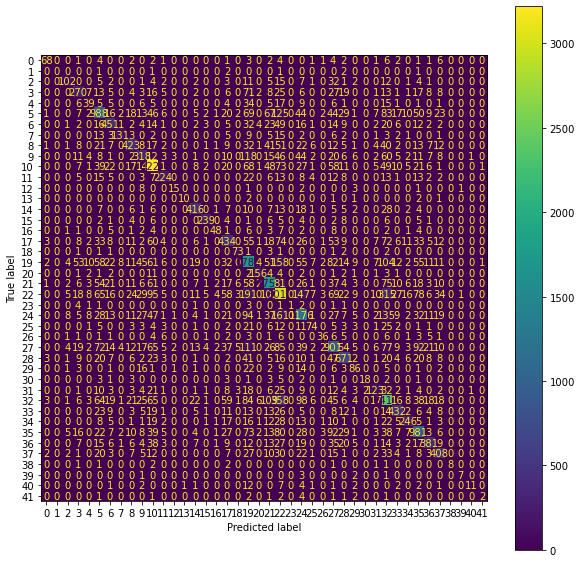

In [24]:
print("Stage 1")
stage1.classifier.Logistic_regression.get_metrics()

Stage 2
- Accuracy: 73.43%
- Specifity: 98.85%
- Sensitivity: 59.74%
- Precision: 65.94%
                                           precision    recall  f1-score   support

                                                0.91      0.53      0.67        19
                     adulteration / fraud       0.64      0.54      0.59       812
                                allergens       0.77      0.80      0.79      1625
          biological contaminants (other)       0.67      0.60      0.63       447
            chemical contaminants (other)       0.75      0.15      0.25        20
                              composition       0.76      0.80      0.78      3318
                 environmental pollutants       0.81      0.80      0.80      1208
                           feed additives       0.68      0.31      0.42        55
           food additives and flavourings       0.65      0.61      0.63      1689
                           foreign bodies       0.68      0.60      0.64      13

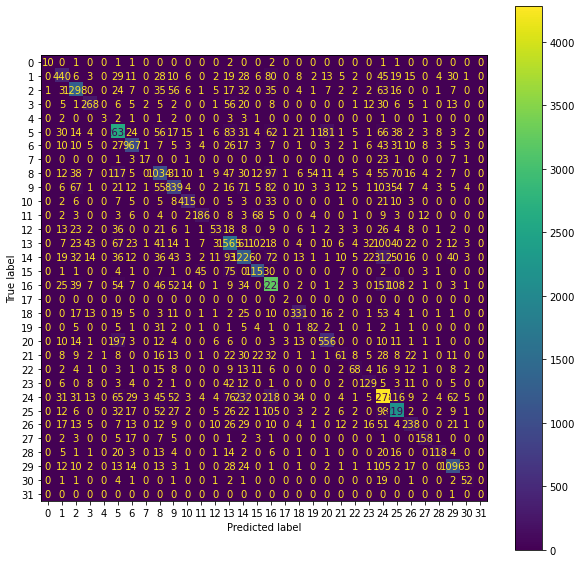

In [25]:
print("Stage 2")
stage2.classifier.Logistic_regression.get_metrics()

Stage 3
- Accuracy: 67.37%
- Specifity: 98.02%
- Sensitivity: 50.02%
- Precision: 59.44%
                                              precision    recall  f1-score   support

                                                   0.60      0.49      0.54      1995
                                  (obsolete)       0.61      0.65      0.63      2318
         (requested) removal of online offer       0.86      0.32      0.46        19
                                 destruction       0.59      0.57      0.58      2830
                        detained by operator       0.62      0.59      0.61       453
distribution restricted to notifying country       0.00      0.00      0.00         1
                       import not authorised       0.59      0.61      0.60      1260
                       informing authorities       0.63      0.54      0.58      1004
                         informing consignor       0.80      0.49      0.60       173
                      informing recipient(s)      

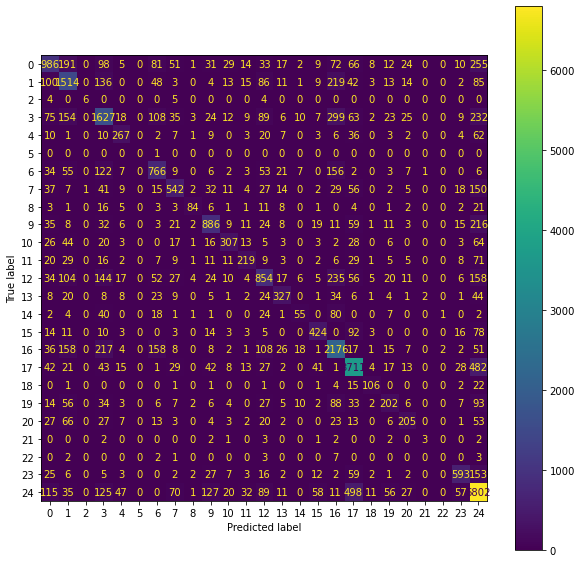

In [26]:
print("Stage 3")
stage3.classifier.Logistic_regression.get_metrics()

### Support vector machine

In [ ]:
class SupportVectorMachine:
    def __init__(self, stage, params):
        self.stage = stage
        self.params = params
        
        self.classifier = GridSearchCV(SVC(), self.params, refit=True, verbose=3, cv=2)
        self.classifier.fit(stage.x_train, stage.y_train.values.ravel())

        self.best_params = self.classifier.best_params_

        self.classifier = SVC(**self.best_params)
        self.classifier.fit(stage.x_train, stage.y_train.values.ravel())

        self.y_predict = None

    def predict(self):
        self.y_predict = self.classifier.predict(self.stage.x_test)

    def get_metrics(self):
        print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
        print(f"- Specifity: {round(get_specifity(self.stage.y_test.values, self.y_predict)*100, 2)}%")
        print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
        print(f"- Precission: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
        
        print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

        cm = confusion_matrix(self.stage.y_test, self.y_predict)
        cm = ConfusionMatrixDisplay(confusion_matrix=cm)

        _, ax = plt.subplots(figsize=(10, 10))
        cm.plot(ax=ax)

In [ ]:
params = {
	"C": [0.1, 1, 10], 
    "gamma": [1, 0.1, 0.01],
    "kernel": ["rbf"]
} 

stage1.classifier.support_vector_machine = SupportVectorMachine(stage1, params)
print(f"Stage 1 completed: {stage1.classifier.support_vector_machine.best_params}")

stage2.classifier.support_vector_machine = SupportVectorMachine(stage2, params)
print(f"Stage 2 completed: {stage2.classifier.support_vector_machine.best_params}")

stage3.classifier.support_vector_machine = SupportVectorMachine(stage3, params)
print(f"Stage 3 completed: {stage3.classifier.support_vector_machine.best_params}")

In [ ]:
stage1.classifier.support_vector_machine.predict()
stage2.classifier.support_vector_machine.predict()
stage3.classifier.support_vector_machine.predict()

In [ ]:
print("Stage 1")
stage1.classifier.support_vector_machine.get_metrics()

In [ ]:
print("Stage 2")
stage2.classifier.support_vector_machine.get_metrics()

In [ ]:
print("Stage 3")
stage3.classifier.support_vector_machine.get_metrics()